In [20]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)



# 初始化模型参数
softmax回归的输出层是⼀个全连接层。因此，为了实现我们的模型，我们只需在Sequential中添加⼀个带有10个输出的全连接层。同样，在这⾥Sequential并不是必要的，但它是实现深度模型的基础。我们仍然以均值0和标准差0.01随机初始化权重。


In [15]:
# PyTorch不会隐式地调整输⼊的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整⽹络输⼊的形状

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);


# 重新审视Softmax的实现
在前⾯的例⼦中，我们计算了模型的输出，然后将此输出送⼊交叉熵损失。从数学上讲，这是⼀件完全合理的事情。然⽽，从计算⻆度来看，指数可能会造成数值稳定性问题。  
回想⼀下，softmax函数yˆj = exp(oj )/∑_k exp(ok)，其中yˆj是预测的概率分布。oj是未规范化的预测o的第j个元素。如果o_k中的⼀些数值⾮常⼤，那么exp(ok)可能⼤于数据类型容许的最⼤数字，即上溢（overflow）。这将使分
⺟或分⼦变为inf（⽆穷⼤），最后得到的是0、inf或nan（不是数字）的yˆj。在这些情况下，我们⽆法得到⼀个明确定义的交叉熵值。

解决方案：在继续softmax计算之前，先从所有ok中减去max(ok)。这⾥可以看到每个ok按常数进⾏的移动不会改变softmax的返回值：  
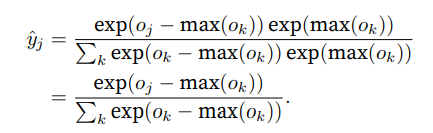  

在减法和规范化步骤之后，可能有些oj − max(ok)具有较⼤的负值。由于精度受限，exp(oj − max(ok))将有接近零的值，即下溢（underflow）。这些值可能会四舍五⼊为零，使yˆj为零，并且使得log(ˆyj )的值为-inf。反向传播⼏步后，我们可能会发现⾃⼰⾯对⼀屏幕可怕的nan结果。  

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。通过将softmax和交叉熵结合在⼀起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。如下⾯的等式所⽰，我们避免计算exp(oj − max(ok))，⽽可以直接使⽤oj − max(ok)，因为log(exp(·))被抵消了。  
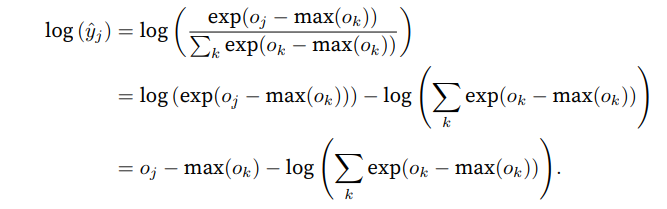  

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。但是，我们没有将softmax概率传递到损失函数中，⽽是在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数，这是⼀种类似“LogSumExp技巧”57的聪明⽅式。

简单来说，指数可能会造成稳定性问题，我们采取取log的方法，抵消掉exp()。




In [16]:
#交叉熵损失函数
#其实Softmax操作应该是在CrossEntropyLoss中实现了，其满足了反向传播的需要，也通过特殊的技巧避免了溢出的问题
loss = nn.CrossEntropyLoss()

# 优化算法
在这⾥，我们使⽤学习率为0.1的⼩批量随机梯度下降作为优化算法。这与我们在线性回归例⼦中的相同，这说明了优化器的普适性。

In [17]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)


# 训练


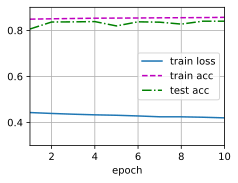

In [19]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
